In [5]:
#!python -m spacy download pl_core_news_lg
import pandas as pd
import numpy as np
import language_tool_python
import os
from datetime import datetime
import re
import tqdm
import random
from functions import *
from evaluation_functions import *
import pandas as pd
import itertools
from itertools import product
tool = language_tool_python.LanguageTool('pl')
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

## Introduction


* The following code aims at using pretrained polish BERT models for tweet classifications. 
* Dataset has been labeled to classify all netrual/not relevant tweets as neutral.
* This allows for filtering out noise - tweets that aren't aimed at specific company.
* Models used were chose based on the KLEJ bechmark t(https://klejbenchmark.com/leaderboard/).

### Preparing training dataset

In [ ]:
# dataset_1 = pd.read_csv('TrainingData/annotation_dataset - general_label.csv',index_col=0)
# dataset_2 = pd.read_csv('TrainingData/annotation_dataset - annotation_second_round_labeled.csv',index_col=0)

# dataset_1 = dataset_1[['text','Overall']]
# dataset_1 =  dataset_1.rename(columns={'Overall':'labels'})

# dataset_2 = dataset_2[['text','label']]
# dataset_2 =  dataset_2.rename(columns={'label':'labels'})

In [2]:
all_columns = pd.read_csv(r'TrainingData\FINAL_TWEET_DATA.csv')

In [ ]:
all_columns['stock_company'].unique()

array(['ALLEGRO', 'INPOST', 'XTB', 'CDR', 'ZABKA', 'MENTZEN', 'CCC',
       '11BIT'], dtype=object)

In [75]:
all_columns = pd.read_csv(r'TrainingData\dataset_labeled.csv', nrows=0).columns.tolist()

columns_to_exclude = ['Unnamed: 0','Unnamed: 0.1' , 'Unnamed: 0.2']  # example columns to skip
wanted_columns = [col for col in all_columns if col not in columns_to_exclude]

dataset_labeled = pd.read_csv(r'TrainingData\dataset_labeled.csv', usecols=wanted_columns)

dataset_labeled['labels'] = dataset_labeled['labels'] + 1

dataset_labeled = dataset_labeled.dropna()
dataset_labeled = dataset_labeled.drop_duplicates(subset='text')

dataset_labeled['labels'] = dataset_labeled['labels'].astype(int)

##### Training dataset is imbalanced what will be addressed in the later stage of the analysis. 

In [ ]:
count = dataset_labeled['labels'].value_counts()
count.plot(kind='bar')

Max length will be set as 128. It covers more than 95% of observations

In [ ]:
%%capture --no-display
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
tweet_lengths = [len(tokenizer.tokenize(tweet)) for tweet in dataset_labeled["text"]]

In [ ]:
print(f"95th percentile: {np.percentile(tweet_lengths, 95)}")  
print(f"Max tokens: {max(tweet_lengths)}")

In [4]:
def aggregate_metrics(metrics_list):
    return {
        key: np.mean([m[key] for m in metrics_list])
        for key in metrics_list[0]
    }


In [5]:
def cross_val_score(df, params = None, model_name = 'allegro/herbert-base-cased', strategy_name = None):
    required = ['train_seed', 'model_seed']
    if any(param not in params for param in required):
        raise ValueError("Missing required config parameters.")
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=params['train_seed'])
    all_fold_metrics = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(df['text'], df['labels'])):
        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]

        # Tokenize if needed
        train_df_tokenized = tokenize_datasets(df = train_df, model_name=model_name, max_length=128, column='text')
        val_df_tokenized = tokenize_datasets(df = val_df, model_name=model_name, max_length=128, column='text')

        dataset_dict = DatasetDict({
            'train': train_df_tokenized,
            'test': val_df_tokenized
        })
        # Train model and get metrics (e.g., accuracy, F1, etc.)
        if strategy_name:
            metrics = run_evaluation(params = params, tokenized_dataset = dataset_dict, model = model_name, strategy_name= strategy_name)
        else:
            metrics = train_evaluate_grid(params = params, tokenized_dataset= dataset_dict, model_name = model_name)
            
        all_fold_metrics.append(metrics)

    # Return average metrics across folds
    return aggregate_metrics(all_fold_metrics)


# Evaluating Text Preprocessing Strategies for BERT Classification


To evaluate the impact of different text preprocessing techniques on BERT model performance using a systematic comparison approach.

#### Methodology
A baseline BERT model with default parameters was trained on each preprocessed version of the datasets. Due to class imbalance and the focus on positive/negative classification, the F1 score serves as the primary evaluation metric.

#### Preprocessing Strategies
The first part was training the model with different basic preprocessing strategies.
Then we evaluated six distinct preprocessing approaches, incrementally adding complexity to assess the impact of each step:

1. Raw text without any preprocessing
2. Removal of non-textual characters
3. Conversion of emojis to corresponding text + Removal of non-textual characters
4. Removal of non-textual characters + Spelling correction
5. Removal of non-textual characters + Spelling correction + Lemmatization
6. Removal of non-textual characters + Spelling correction + Lemmatization + Stopword removal

Model performance is evaluated using the F1 score, which provides a balanced measure of precision and recall, particularly important for our imbalanced dataset classification task.

In [71]:
#Removing http
def preprocess_tweet_https(tweet):
    tweet = re.sub(r'http\S+|www\S+|https\S+', ' ', tweet, flags=re.MULTILINE)
    return tweet

#Removing hashtags
def preprocess_tweet_hashtag(tweet):
    tweet = re.sub(r'#\w+', ' ', tweet)
    return tweet

#Removing mentions
def preprocess_tweet_mention(tweet):
    tweet = re.sub(r'@\w+', ' ', tweet)
    return tweet

#Removing cashtag
def preprocess_tweet_cashtag(tweet):
    tweet = re.sub(r'\$\w+', ' ', tweet)
    return tweet

#Removing all charatcters except polish letter and ? !
def preprocess_tweet_text(tweet):
    tweet = re.sub(r'[^a-zA-ZĄąĆćĘęŁłŃńÓóŚśŹźŻż0-9\s?!]', ' ', tweet)
    return tweet

#Removing repeated letters
def preprocess_tweet_rep(tweet):
    tweet = re.sub(r'(.)\1+', r'\1', tweet)
    return tweet

#Removing white spaces
def preprocess_tweet_norm(tweet):
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

#Normalizing caps
def preprocess_caps(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'(^|[.!?]\s+)(\w)', lambda m: m.group(1) + m.group(2).upper(), tweet)
    return tweet

def preprocess_tco(tweet):
    return re.sub(r"https?://t\.co/\S+", "", tweet).strip()

In [70]:
def preprocess_tweet(tweet):
    tweet = preprocess_tweet_mention(tweet)
    tweet = preprocess_tweet_https(tweet)
    return tweet

In [72]:
# Processing pipelines
basic_processing_pipelines = {
    'No_processing': [],
    'No_processing_emoji': [
        replace_emoji
    ],
    'No_processing_http': [
        preprocess_tweet_https
    ],
    'No_processing_hashtag': [
        preprocess_tweet_hashtag
    ],
    'No_processing_mention': [
        preprocess_tweet_mention
    ],
    'No_processing_cashtag': [
        preprocess_tweet_cashtag
    ],
    'No_processing__text': [
        preprocess_tweet_text
    ],
    'No_processing__rep': [
        preprocess_tweet_rep
    ],
    'No_processing_norm': [
        preprocess_tweet_norm
    ],
    'No_processing_caps': [
        preprocess_caps
    ]
}

### Parameter setup

In [73]:
tested_models = {}
tested_models['ROBERT'] = "sdadas/polish-roberta-base-v2"
tested_models['HERBERT']  = "allegro/herbert-base-cased"
tested_models['POLBERT']  = "dkleczek/bert-base-polish-cased-v1"
tested_models['MBERT'] = 'google-bert/bert-base-multilingual-cased'

### Find best basic data preprocessing 

In [ ]:
os.path.exists(r'./preprocessing_comparison') or os.makedirs(r'./preprocessing_comparison')
os.path.exists(r'./results') or os.makedirs(r'./results')

datasets = transform_data(processing_pipelines = basic_processing_pipelines,dataset=dataset_labeled, csv_dir='TrainingData/')

params={'train_seed': [12], 'model_seed': [12,53,42]}
all_params = [dict(zip(params.keys(), values)) 
             for values in itertools.product(*params.values())]

all_combinations = list(product(all_params, tested_models.values(), datasets.keys()))

for params_set, model, dataset_name in tqdm.tqdm(all_combinations, desc="Grid Search", total=len(all_combinations)):
    try:
        print(f"Processing dataset: {dataset_name}")
        # Run cross-validation
        print(f"Running cross-validation with params: {params_set}")
        cv_results = cross_val_score(df=datasets[dataset_name], params = params_set, model_name=model, strategy_name=dataset_name)
        # Save results
        results_df = pd.DataFrame(cv_results, index=[0])
        results_df['model_seed'] = params_set['model_seed']
        results_df['train_seed'] = params_set['train_seed']
        results_df['model'] = model
        results_df['dataset'] = dataset_name
        timestamp = datetime.now().strftime('%Y%m%d_%' \
        'H%M%S')
        results_df.to_csv(rf"./preprocessing_comparison/preprocessing_comparison_model_{model[:4]}_{params_set['train_seed']}_{timestamp}.csv", index=False)
        print(f"\nComparison saved to preprocessing_comparison_model_{model[:4]}.csv")
       
    except Exception as e:
        print(f"Skipping failed params {params_set}: {str(e)}")

In [6]:
def compile_results(directory):
    """Compiles and processes results from CSV files in 'preprocessing_comparison' directory."""
    combined_df = pd.DataFrame()

    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            combined_df = pd.concat([combined_df, df], ignore_index=True)

    # Filter and drop only if columns exist
    if 'seed' in combined_df.columns:
        combined_df = combined_df[combined_df['seed'] < 5]
        combined_df.drop(['seed'], axis=1, inplace=True, errors='ignore')

    combined_df.drop(['epochs'], axis=1, inplace=True, errors='ignore')
    combined_df.sort_values(by=['model', 'dataset'], inplace=True)

    return combined_df

all_results = compile_results('preprocessing_comparison')

In [102]:
cols_to_use = all_results.select_dtypes(include='number').columns.drop('model_seed')
model_comparison = all_results.groupby(['model'])[cols_to_use].agg('mean').reset_index()
display(model_comparison)

,model,train_seed,accuracy,macro_f1,weighted_f1,neutral_f1,positive_f1,negative_f1
0,allegro/herbert-base-cased,12.0,0.734569,0.674289,0.729294,0.667942,0.806562,0.548364
1,dkleczek/bert-base-polish-cased-v1,12.0,0.718034,0.657654,0.716133,0.617981,0.802604,0.552376
2,google-bert/bert-base-multilingual-cased,12.0,0.637514,0.512654,0.614415,0.427081,0.767106,0.343775
3,sdadas/polish-roberta-base-v2,12.0,0.746337,0.692917,0.743596,0.690244,0.814337,0.574170


e:\Project_clean\PolishTweetsClassification\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
e:\Project_clean\PolishTweetsClassification\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
e:\Project_clean\PolishTweetsClassification\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key

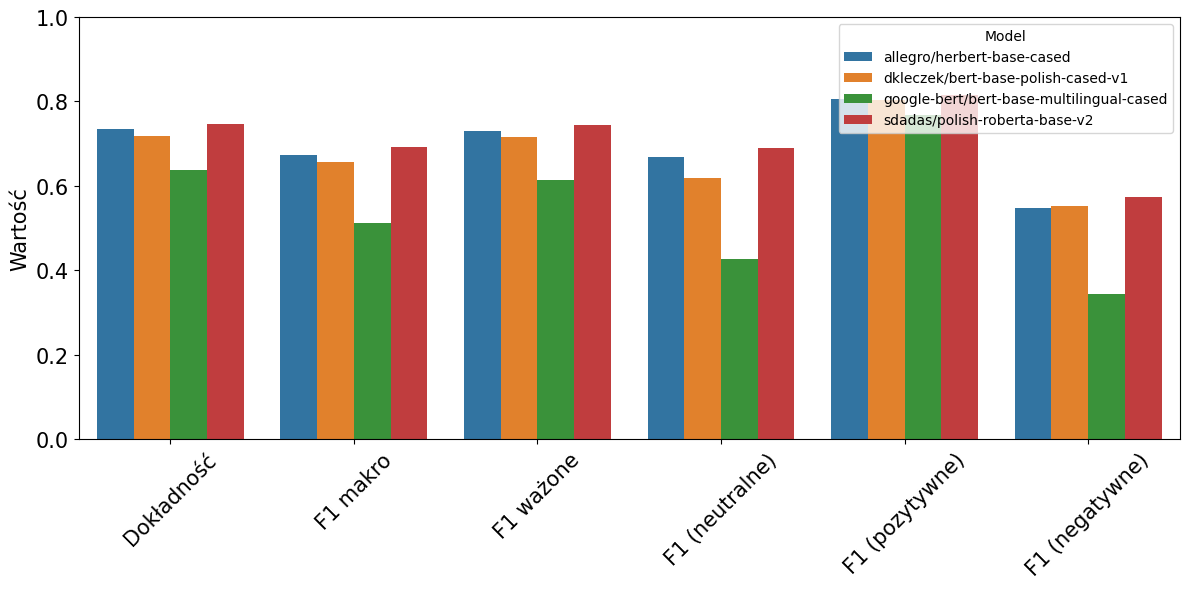

In [101]:
metrics = ['accuracy', 'macro_f1', 'weighted_f1', 'neutral_f1', 'positive_f1', 'negative_f1']
df_melted = model_comparison.melt(id_vars=['model'], value_vars=metrics,
                    var_name='metric', value_name='value')
metric_translation = {
    'accuracy': 'Dokładność',
    'macro_f1': 'F1 makro',
    'weighted_f1': 'F1 ważone',
    'neutral_f1': 'F1 (neutralne)',
    'positive_f1': 'F1 (pozytywne)',
    'negative_f1': 'F1 (negatywne)'
}
df_melted['metric_pl'] = df_melted['metric'].map(metric_translation)
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='metric_pl', y='value', hue='model')
plt.title("")
plt.xticks(rotation=45, fontsize=15)
plt.ylabel("Wartość", fontsize=15)
plt.legend(title='Model', loc='upper right')
plt.yticks(fontsize=15)
plt.ylim(0, 1)
plt.xlabel("")
plt.tight_layout()
plt.show()

C:\Users\szymo\AppData\Local\Temp\ipykernel_29804\843588518.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.loc[:,'dataset'].replace(to_replace=zmiana_nazw, inplace = True)
e:\Project_clean\PolishTweetsClassification\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
e:\Project_clean\

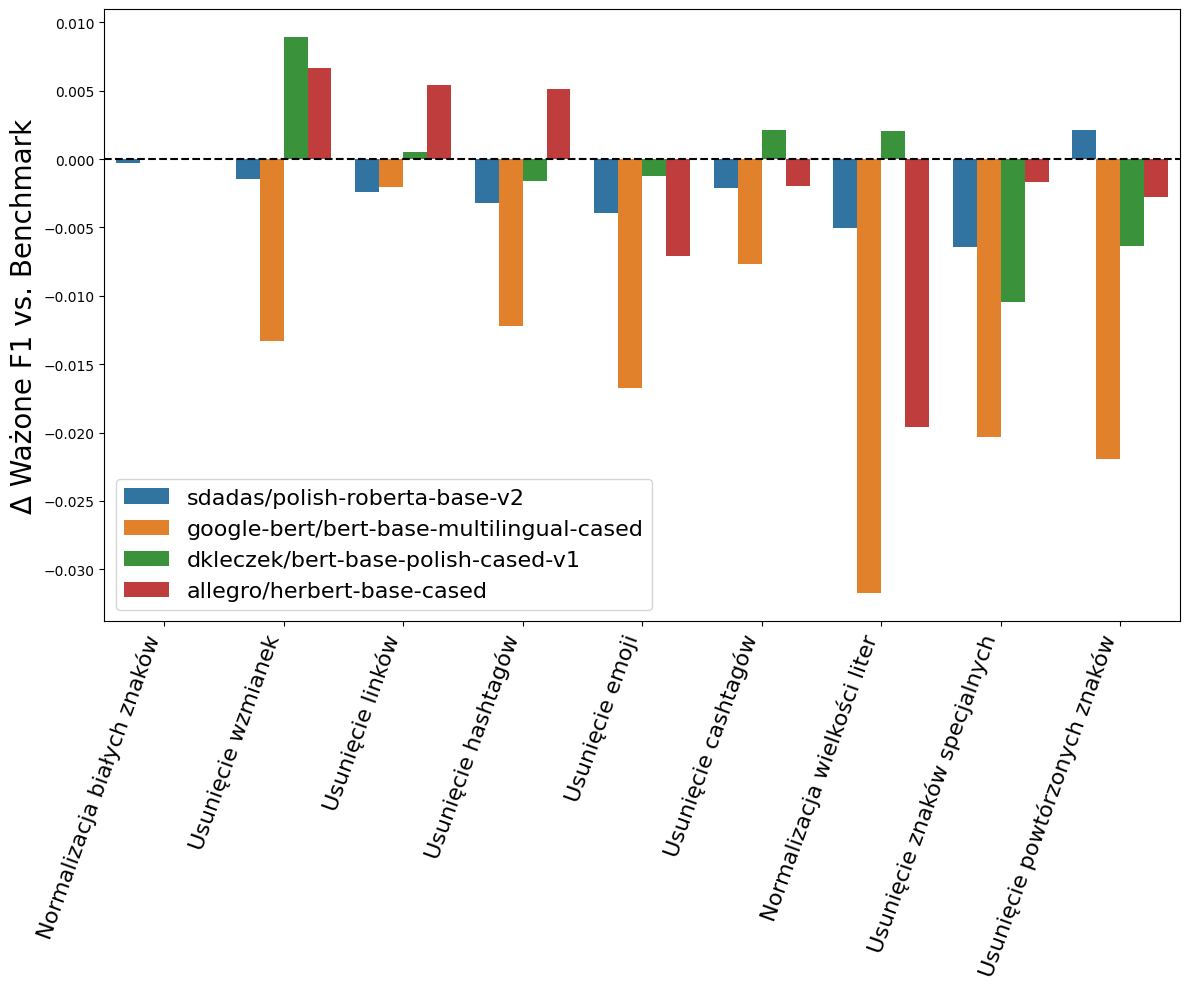

In [ ]:
cols_to_use = all_results.select_dtypes(include='number').columns.drop('model_seed')
pre_processing = all_results.groupby(['dataset', 'model'])['weighted_f1'].agg('mean').reset_index().sort_values(by = ['model','dataset','weighted_f1'], ascending = False)
benchmark = pre_processing.loc[pre_processing['dataset']=='No_processing',['model','weighted_f1']]

df = pd.merge(pre_processing, benchmark, on='model', suffixes=('', '_benchmark'))
df['dataset'].unique().tolist()
zmiana_nazw  = {'No_processing_norm': 'Normalizacja białych znaków',
 'No_processing_mention' : 'Usunięcie wzmianek',
 'No_processing_http': 'Usunięcie linków',
 'No_processing_hashtag': 'Usunięcie hashtagów',
 'No_processing_emoji': 'Usunięcie emoji',
 'No_processing_cashtag': 'Usunięcie cashtagów',
 'No_processing_caps': 'Normalizacja wielkości liter',
 'No_processing__text': 'Usunięcie znaków specjalnych',
 'No_processing__rep': 'Usunięcie powtórzonych znaków', 
 'No_processing': 'Brak przetwarzania'}

df.loc[:,'dataset'].replace(to_replace=zmiana_nazw, inplace = True)


baseline = df[df['dataset'] == 'Brak przetwarzania'][['model', 'weighted_f1']]
baseline = baseline.rename(columns={'weighted_f1': 'baseline_f1'})

# Merge baseline back to the full dataset
df = df.merge(baseline, on='model')

# Calculate the difference
df['delta'] = df['weighted_f1'] - df['baseline_f1']

# Filter out the baseline itself (we don't need to compare it to itself)
df_filtered = df[df['dataset'] != 'Brak przetwarzania']

# Plot the delta
plt.figure(figsize=(12, 10))
sns.barplot(data=df_filtered, x='dataset', y='delta', hue='model')
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=70, ha='right', fontsize=16)
#plt.title("Zmiana w ważonym F1 w porównianiu do Benchmark (No_processing) dla różnych modeli")
plt.ylabel("Δ Ważone F1 vs. Benchmark", fontsize=20)
plt.xlabel("", fontsize=20)

plt.legend(prop={'size': 16})

plt.tight_layout()
plt.show()

### Find best data preprocessing strategy

In [78]:
strategies_processing_pipelines = {
    'Basic_processing': [
        preprocess_tweet
    ],
    'Basic_processing_spelling': [
        preprocess_tweet,
        tool.correct
    ],
    'Basic_processing_spelling_lem': [
        preprocess_tweet,
        tool.correct,
        lemmatize_text
    ],
    'Basic_processing_spelling_SP': [
        preprocess_tweet,
        tool.correct,
        remove_stops
    ],
    'Basic_processing_spelling_lem_SP': [
        preprocess_tweet,
        tool.correct,
        lemmatize_text,
        remove_stops
    ]
}

In [ ]:
datasets = transform_data(processing_pipelines = strategies_processing_pipelines, dataset=dataset_labeled, csv_dir='TrainingData/')
os.path.exists(r'./strategy_comparison') or os.makedirs(r'./strategy_comparison')

datasets = transform_data(processing_pipelines = strategies_processing_pipelines,dataset=dataset_labeled, csv_dir='TrainingData/')

params={'train_seed': [12], 'model_seed': [12,53,42]}
all_params = [dict(zip(params.keys(), values)) 
             for values in itertools.product(*params.values())]

all_combinations = list(product(all_params, tested_models.values(), datasets.keys()))

for params_set, model, dataset_name in tqdm.tqdm(all_combinations, desc="Grid Search", total=len(all_combinations)):
    try:
        print(f"Processing dataset: {dataset_name}")
        # Run cross-validation
        print(f"Running cross-validation with params: {params_set}")
        cv_results = cross_val_score(df=datasets[dataset_name], params = params_set, model_name=model, strategy_name=dataset_name)
        # Save results  
        results_df = pd.DataFrame(cv_results, index=[0])
        results_df['model_seed'] = params_set['model_seed']
        results_df['train_seed'] = params_set['train_seed']
        results_df['model'] = model
        results_df['dataset'] = dataset_name
        timestamp = datetime.now().strftime('%Y%m%d_%' \
        'H%M%S')
        results_df.to_csv(rf"./strategy_comparison/preprocessing_comparison_model_{model[:4]}_{params['train_seed']}_{timestamp}.csv", index=False)
        print(f"\nComparison saved to preprocessing_comparison_model_{model[:4]}.csv")
       
    except Exception as e:
        print(f"Skipping failed params {params_set}: {str(e)}")

In [136]:
all_results = compile_results('strategy_comparison')

C:\Users\szymo\AppData\Local\Temp\ipykernel_29804\713083708.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.loc[:,'dataset'].replace(to_replace=zmiana_nazw, inplace = True)
e:\Project_clean\PolishTweetsClassification\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


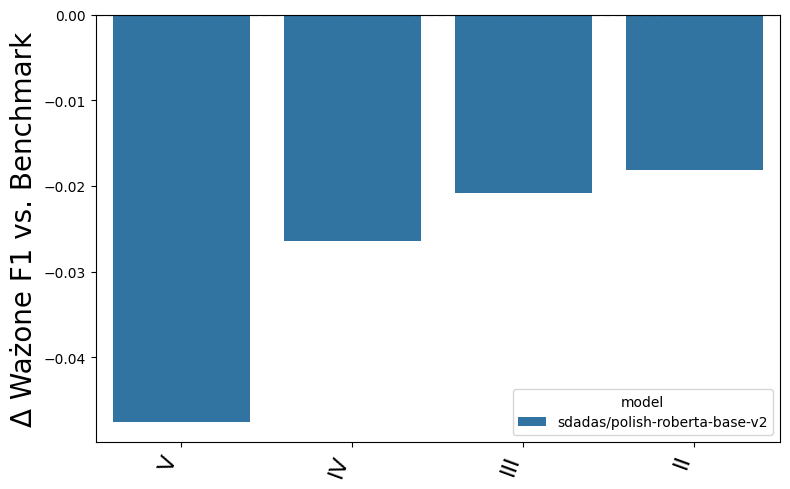

In [147]:
cols_to_use = all_results.select_dtypes(include='number').columns
pre_processing = all_results.groupby(['dataset', 'model'])['weighted_f1'].agg('mean').reset_index().sort_values(by = ['model','dataset','weighted_f1'], ascending = False)
df = pre_processing
baseline = df[df['dataset'] == 'Basic_processing'][['model', 'weighted_f1']]
baseline = baseline.rename(columns={'weighted_f1': 'baseline_f1'})

zmiana_nazw  = {'Basic_processing': 'I',
 'Basic_processing_spelling': 'II',
 'Basic_processing_spelling_SP': 'III',
 'Basic_processing_spelling_lem': 'IV',
 'Basic_processing_spelling_lem_SP': 'V'
}

# zmiana_nazw  = {'Basic_processing': 'Podst. przetw.',
#  'Basic_processing_spelling': 'Podst. przetw. z korektą ',
#  'Basic_processing_spelling_SP': 'Podst. przetw. z korektą  i usuwaniem wyrazów stopu',
#  'Basic_processing_spelling_lem': 'Podst. przetw. z korektą  i lematyzacją',
#  'Basic_processing_spelling_lem_SP': 'Podst. przetw. z korektą, lematyzacją i bez stop words'
# }

df.loc[:,'dataset'].replace(to_replace=zmiana_nazw, inplace = True)

# Merge baseline back to the full dataset
df = df.merge(baseline, on='model')

# Calculate the difference
df['delta'] = df['weighted_f1'] - df['baseline_f1']

# Filter out the baseline itself (we don't need to compare it to itself)
df_filtered = df[df['dataset'] != 'I']

# Plot the delta
plt.figure(figsize=(8, 5))
sns.barplot(data=df_filtered, x='dataset', y='delta', hue='model')
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=70, ha='right', fontsize=16)
plt.ylabel("Δ Ważone F1 vs. Benchmark", fontsize=20)
plt.xlabel("", fontsize=20)

plt.tight_layout()
plt.show()

In [106]:
all_results

,train_seed,model_seed,accuracy,macro_f1,weighted_f1,neutral_f1,positive_f1,negative_f1,model,dataset
0,12,12,0.739259,0.681820,0.736022,0.649093,0.813605,0.582762,sdadas/polish-roberta-base-v2,Basic_processing
5,12,53,0.730864,0.675277,0.729191,0.662166,0.803800,0.559864,sdadas/polish-roberta-base-v2,Basic_processing
10,12,42,0.750123,0.697842,0.747493,0.680510,0.816928,0.596086,sdadas/polish-roberta-base-v2,Basic_processing
1,12,12,0.729877,0.672864,0.727321,0.654872,0.803286,0.560433,sdadas/polish-roberta-base-v2,Basic_processing_spelling
6,12,53,0.711111,0.619529,0.694472,0.638722,0.793213,0.426650,sdadas/polish-roberta-base-v2,Basic_processing_spelling
11,12,42,0.740247,0.681763,0.736315,0.679540,0.810328,0.555421,sdadas/polish-roberta-base-v2,Basic_processing_spelling
3,12,12,0.719506,0.637962,0.708800,0.648091,0.803177,0.462617,sdadas/polish-roberta-base-v2,Basic_processing_spelling_SP
8,12,53,0.722469,0.652805,0.715862,0.660621,0.800025,0.497767,sdadas/polish-roberta-base-v2,Basic_processing_spelling_SP
13,12,42,0.734321,0.662021,0.725428,0.667669,0.810346,0.508049,sdadas/polish-roberta-base-v2,Basic_processing_spelling_SP
2,12,12,0.713580,0.646310,0.708577,0.626540,0.795298,0.517090,sdadas/polish-roberta-base-v2,Basic_processing_spelling_lem


### Grid search with best preprocessing strategy


In [ ]:
strategies_processing_pipelines['Basic_processing']

In [ ]:
processing_pipelines = {}
processing_pipelines['Basic_processing'] = strategies_processing_pipelines['Basic_processing']

In [ ]:
dataset = transform_data(processing_pipelines = processing_pipelines,dataset=dataset_labeled, csv_dir='TrainingData/')

In [ ]:
param_grid = {
    "learning_rate": [1e-5,1.5e-5, 2e-5],     
    "batch_size": [4,8, 16],               
    "epochs": [3,4,5],                    
    "weight_decay": [0.05,0.01, 0.001],       
    "class_weight_floor": [0.5, 1.0],
    "seed": [42],  
}

# Generate parameter combinations
all_params = [dict(zip(param_grid.keys(), values)) 
             for values in itertools.product(*param_grid.values())]

random.seed(42)
model = tested_models['ROBERT']
sample_size = 1
random_params = random.sample(all_params, k=sample_size)
n_trials = len(random_params)

for trial_num, params in enumerate(random_params):
    print(f"Running CV for config {trial_num + 1}/{n_trials}")

    avg_metrics = cross_val_score(params = params, df = dataset['Basic_processing'], model_name = model)
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    # Log to CSV or memory
    results.append({**params, **avg_metrics})
    pd.DataFrame(results).to_csv(
            rf"./grid_search_comparison/preprocessing_comparison_model_{model[:4]}_{timestamp}.csv",
            index=False
        )
    


In [ ]:
test_size = 0.2
os.path.exists(r'./grid_search_comparison') or os.makedirs(r'./grid_search_comparison')
# Parameter grid with class-aware parameters
param_grid = {
    "learning_rate": [1e-5,1.5e-5, 2e-5],     
    "batch_size": [4,8, 16],               
    "epochs": [3,4,5],                    
    "weight_decay": [0.05,0.01, 0.001],       
    "class_weight_floor": [0.5, 1.0],
    "seed": [42],  
}

# Generate parameter combinations
all_params = [dict(zip(param_grid.keys(), values)) 
             for values in itertools.product(*param_grid.values())]

random.seed(42)
model = tested_models['ROBERT']
sample_size = 5
random_params = random.sample(all_params, k=sample_size)

# Run grid search with progress tracking
results = []
for params in tqdm.tqdm(random_params, desc="Grid Search"):
    try:
        tokenized_dataset = prepare_datasets(df = dataset['Basic_processing'], model = model, test_size=test_size, random_state=params['seed'], max_length=128, column='text')
        result = train_evaluate_grid(params, tokenized_dataset, model_name=model)
        if result:  # Only store successful runs
            results.append(result)
            results_df = pd.DataFrame(results)
            results_df['params'] = params
        
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        
            results_df.to_csv(rf"./grid_search_comparison/preprocessing_comparison_model_{model[:4]}_{train_test_seed}_{timestamp}.csv", index=False)
            print(f"\nComparison saved to preprocessing_comparison_model_{model[:4]}.csv")
    except Exception as e:
        print(f"Skipping failed params {params}: {str(e)}")

# Save and analyze results
if results:
    results_df = pd.DataFrame(results)
    results_df.to_csv("grid_search_results_robust.csv", index=False)
    print("Saved results to grid_search_results_robust.csv")
else:
    print("No successful runs completed")